# Libs and pre-definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import sklearn
from sklearn import gaussian_process
from scipy import optimize,stats

# Functions

$$ F(x,\omega,\gamma) = \prod_{i=1}^{N} sin(\omega X_i)tanh(\gamma X_i^2) + \epsilon, \quad \epsilon \sim \mathcal{N}(0,\sigma)$$

In [2]:
def olivers_fn(X:np.array,w:float = 5,gamma:float = 0.3,noise = False):
    y = np.prod(np.sin(w*(X))*(1-np.tanh(gamma*((X)**2))),-1,keepdims=True)
    if noise:
        y += np.random.normal(0,noise,y.shape)
    return y

In [3]:
NOISE = 0.1

# Plot

In [4]:

N = 25
x = np.expand_dims(np.linspace(-5,5,10000),-1)
x_sample = np.random.normal(0,1,(N,1))#np.random.uniform(low=-4, high=4, size=(25,1)) #

y_true = olivers_fn(x,noise = 0)
y_sample = olivers_fn(x_sample,noise = NOISE)

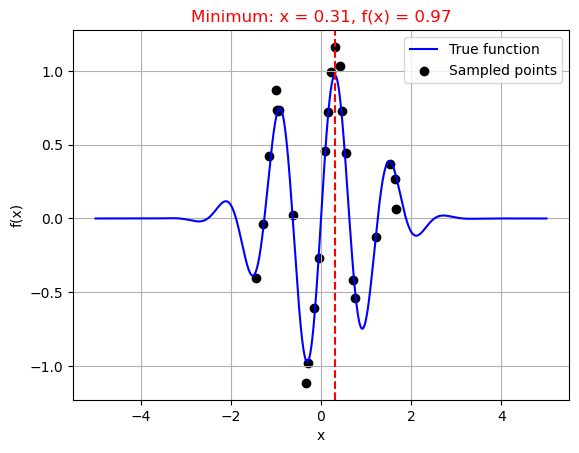

In [5]:
plt.plot(x,y_true, color = 'blue', label = 'True function')
plt.scatter(x_sample,y_sample, color = 'black', label = 'Sampled points')
true_minimal = (x[np.argmax(y_true)].item(),y_true.max())
plt.axvline(x[np.argmax(y_true)],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

# Gaussian Process

In [6]:
kernel = gaussian_process.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0)) + gaussian_process.kernels.WhiteKernel(noise_level=0.1)
gpr = gaussian_process.GaussianProcessRegressor(kernel=kernel,random_state=42).fit(x_sample, y_sample)

In [7]:
y_pred, std = gpr.predict(x,return_std = True)

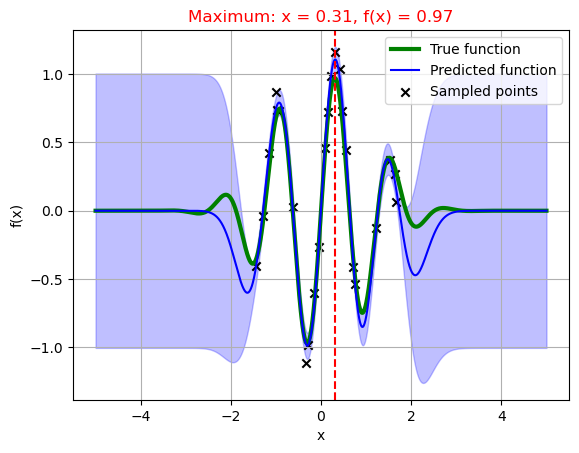

In [8]:
plt.plot(x,y_true, color = 'green', label = 'True function',linewidth = 3)
plt.plot(x,y_pred, color = 'blue', label = 'Predicted function')
plt.fill_between(x.flatten(),y_pred-std,y_pred+std, alpha = 0.25, color = 'blue')
plt.scatter(x_sample,y_sample, color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[np.argmax(y_true)].item(),y_true.max())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


# Optimizer

In [9]:
class BayesianOptimizer():
    
    def __init__(self,true_model,surrogate_model_class,D:tuple = (),initial_x:np.array = np.array([[0]])):
        
        self.true_model = true_model
        self.surrogate_model_class = surrogate_model_class
        if len(D)==0 : self.D = (initial_x,true_model(initial_x))
        elif D[0].size ==0: self.D = (initial_x,true_model(initial_x))
        else: self.D = D
            
        self.i = 1
        
    def fit_surrogate_model(self):
        self.surrogate_model = self.surrogate_model_class.fit(*self.D)
    def calc_expected_improvement(self,x):
        f_hat, std_hat = self.surrogate_model.predict(x,return_std = True)
        f_plus = np.max(self.D[1])
        #Z = (f_hat-f_plus)/(std_hat**2)
        Z = (f_hat-f_plus)/(std_hat)
        return (f_hat-f_plus)*stats.norm.cdf(Z) + std_hat*stats.norm.pdf(Z)
    
    def get_new_x(self,x_range = (-5,5)):
        x_range = np.linspace(*x_range,10000)
        #return x_range[self.calc_expected_improvement(np.expand_dims(x_range,-1)).argmin()]
        return x_range[self.calc_expected_improvement(np.expand_dims(x_range,-1)).argmax()]
    
    def update_D(self,x,y):
        x,y = x.reshape(-1,self.D[0].shape[1]), y.reshape(-1,self.D[1].shape[1])
        self.D = (np.concatenate((self.D[0],x)), np.concatenate((self.D[1],y)))
        
    def run_optimization(self,x_range_suboptimization = (-5,5), **convergence_params):
        while not self.stopping_criterion(**convergence_params):
            self.fit_surrogate_model()
            x = self.get_new_x(x_range_suboptimization)
            y = self.true_model(x)
            self.update_D(x,y)
            self.i += 1
        idx = self.D[1].argmax()
        return self.D[0][idx],self.D[1][idx]
    
    def stopping_criterion(self,**convergence_params):
        return self.i > convergence_params['max_iter']
    

## Random initial points

In [13]:
N_initial_points = 5
initial_x = 5*(np.random.rand(N_initial_points,1)-0.5)
gpr = gaussian_process.GaussianProcessRegressor(kernel=kernel,random_state=42)
BayesOpt = BayesianOptimizer(lambda x: olivers_fn(x,noise=NOISE),gpr,D = (),initial_x = initial_x)

In [14]:
MAX_ITER = 100
x_opt, y_opt = BayesOpt.run_optimization(x_range_suboptimization = (-5,5), max_iter = MAX_ITER)
print(x_opt,y_opt)

/disk/users/lprate/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/disk/users/lprate/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/disk/users/lprate/miniconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/disk/users/lprate/miniconda3/lib/python3.1

[0.29652965] [1.28905674]


### Plot

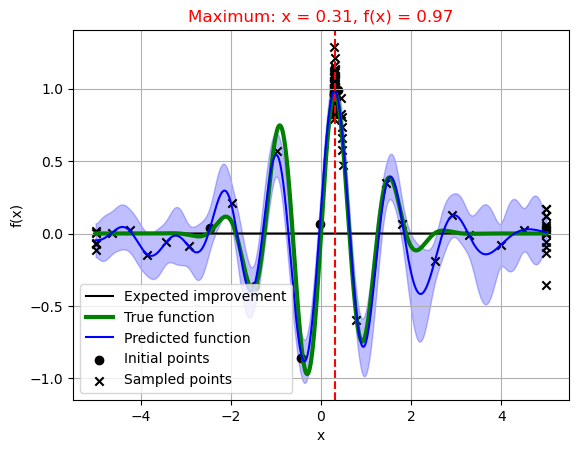

In [15]:
x = np.expand_dims(np.linspace(-5,5,10000),-1)
y_true = olivers_fn(x,noise = 0)
gpr = gpr.fit(*BayesOpt.D)
y_pred, std = gpr.predict(x,return_std = True)


plt.plot(x,BayesOpt.calc_expected_improvement(x), color = 'black', label = 'Expected improvement')
plt.plot(x,y_true, color = 'green', label = 'True function',linewidth = 3)
plt.plot(x,y_pred, color = 'blue', label = 'Predicted function')
plt.fill_between(x.flatten(),y_pred-std,y_pred+std, alpha = 0.25, color = 'blue')
plt.scatter(BayesOpt.D[0][:N_initial_points],BayesOpt.D[1][:N_initial_points], color = 'black', label = 'Initial points', marker = 'o')
plt.scatter(BayesOpt.D[0][N_initial_points:],BayesOpt.D[1][N_initial_points:], color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[np.argmax(y_true)].item(),y_true.max())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()